In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import datetime


import sys
import aiutils.aiutils as ai
import aiutils.aiutils_keras as ker
import aiutils.features_manager as feat
import aiutils.labels_manager as lab
import aiutils.ai_backtester as bt
import aiutils.preprocessing as pr
import talib as ta
import pandas_ta as ta
import matplotlib.pyplot as plt
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, PReLU, ELU, ThresholdedReLU, Conv1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model



from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# Magic commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

pd.options.display.width=None

# Avoid scientific notation when printing numpy arrays in most cases
np.set_printoptions(suppress=True)


# Imprtation des jeux de données et création des features

In [2]:
def create_features(data, adx = True,use_bol = True,macd = True,diff_ll = True,rol_means = True,kama = True,ao = True,aron=True,rsi= True):
        
    for index in range(1,4):
        data = feat.add_ohlc_features(data, f'C{index}O{index}')
        data = feat.add_ohlc_features(data, f'C{index}O{index-1}')
        
        
    feat.add_ohlc_features(data, 'OH1')
    feat.add_ohlc_features(data, 'OL1')

    if rsi:
        data.ta.rsi(append=True)
        data[f'RSI_{14}']=data[f'RSI_{14}'].shift(1)

    if diff_ll:
        data = feat.add_hh_ll(data,periods=3,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=5,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=10,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=15,shift=1,drop_na=False)
        data['LL5LL3'] = 10000*(data['LL5'] - data['LL3'])
        data['LL10LL3'] = 10000*(data['LL10'] - data['LL3'])
        data['LL15LL3'] = 10000*(data['LL15'] - data['LL3'])
        data['HH5HH3'] = 10000*(data['HH5'] - data['HH3'])
        data['HH10HH3'] = 10000*(data['HH10'] - data['HH3'])
        data['HH15HH3'] = 10000*(data['HH15'] - data['HH3'])
        data["OLL3"] = 10000*(data["open"]-data["LL3"])
        data["OLL5"] = 10000*(data["open"]-data["LL5"])
        data["OLL10"] = 10000*(data["open"]-data["LL10"])
        data["OLL15"] = 10000*(data["open"]-data["LL15"])
        data["OHH3"] = 10000*(data["open"]-data["HH3"])
        data["OHH5"] = 10000*(data["open"]-data["HH5"])
        data["OHH10"] = 10000*(data["open"]-data["HH10"])
        data["OHH15"] = 10000*(data["open"]-data["HH15"])

    if use_bol:
        data['MA20'] = data['close'].shift(1).rolling(window=20).mean() 
        data['MA20dSTD'] = data['close'].shift(1).rolling(window=20).std() 
        data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
        data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)


        data['U_minus_L'] = data['Bollinger_Upper'] - data['Bollinger_Lower']
        data['pullback'] = data['close'].shift(1) - data['Bollinger_Upper'].shift(1)
        data['throwback'] = data['close'].shift(1) - data['Bollinger_Lower'].shift(1)

    if rol_means:
        data['CO'] = data['close'] - data['open']
        data['rmCO(3)'] = data['CO'].shift(1).rolling(window=3).mean() 
        data['rmCO(4)'] = data['CO'].shift(1).rolling(window=4).mean() 
        data['rmCO(5)'] = data['CO'].shift(1).rolling(window=5).mean() 
        data['rmCO(6)'] = data['CO'].shift(1).rolling(window=6).mean() 

    if adx:
        for i in [5,7,10]:
            data.ta.adx(i,append=True)
            data[f'ADX_{i}'] = data[f'ADX_{i}'].shift(1)
            data[f'DMP_{i}'] = data[f'DMP_{i}'].shift(1)
            data[f'DMN_{i}'] = data[f'DMN_{i}'].shift(1)

    if ao :
        data.ta.ao(3,6,append=True)
        data[f'AO_{3}_{6}'] = data[f'AO_{3}_{6}'].shift(1)

    if kama:
        data.ta.kama(length=10,slow=30,append=True)
        data[f'OKAMA_{10}_{2}_{30}'] = data['open'] - data[f'KAMA_{10}_{2}_{30}'].shift(1)

    if macd :
        fast_macd=12
        slow_macd=26
        signal_macd =9
        data.ta.macd(fast=fast_macd,slow=slow_macd,signal=signal_macd,append=True)
        data[f'MACD_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACD_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)
        data[f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)
        data[f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)

    if aron:
        lenght_aroon = 7
        data.ta.aroon(length=lenght_aroon,append=True)
        data[f'AROONOSC_{lenght_aroon}'] = data[f'AROONOSC_{lenght_aroon}'].shift(1)
        data[f'AROOND_{lenght_aroon}'] = data[f'AROOND_{lenght_aroon}'].shift(1)
        data[f'AROONU_{lenght_aroon}'] = data[f'AROONU_{lenght_aroon}'].shift(1)


    data.dropna(inplace=True)
    features = []
    if rsi:
        features.append(f'RSI_{14}')
    if ao:
        features.append(f'AO_{3}_{6}')
    if kama:
        features.append(f'OKAMA_{10}_{2}_{30}')
    features.append("weekday")
    if macd :
        features.append(f'MACD_{fast_macd}_{slow_macd}_{signal_macd}')
        features.append(f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}')
        features.append(f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}')
    if aron:
        features.append(f'AROONOSC_{lenght_aroon}')
        features.append(f'AROOND_{lenght_aroon}')
        features.append(f'AROONU_{lenght_aroon}')
    features.append("C1O1")
    features.append("C2O2")

    if rol_means:
        features.append('rmCO(3)')
        features.append('rmCO(4)')
        features.append('rmCO(5)')
        features.append('rmCO(6)')
    features.append("C1O")
    features.append("C2O1")
    features.append("C3O3")
    features.append("C3O2")
    if diff_ll:
        features.append("LL5LL3")
        features.append("LL10LL3")
        features.append("LL15LL3")
        features.append("HH5HH3")
        features.append("HH10HH3")
        features.append("HH15HH3")
        features.append("OLL3")
        features.append("OLL5")
        features.append("OLL10")
        features.append("OLL15")
        features.append("OHH3")
        features.append("OHH5")
        features.append("OHH10")
        features.append("OHH15")
        
    features.append("OH1")
    features.append("OL1")
    if use_bol:
        features.append("U_minus_L")
        features.append("pullback")
        features.append("throwback")
    if adx:
        for i in [5]:
            features.append(f'ADX_{i}')
            #if i != 7:
            features.append(f'DMP_{i}')
            features.append(f'DMN_{i}')

    #features = list(data.columns[7:]) + ['weekday']

    return data, features

In [3]:
pair = 'EURUSD'
path = 'data/shared/data/trading/parquets'
df = ai.read_timeseries_from_csv(filename=f'./{pair}_1H_UTC.csv',closedatetimeref=False,totimescale='1H',fromtimezone='UTC',totimezone='Europe/Paris')
# print((df['close'].shift(-1) - df['close']))
lab.add_close_close(df,nbars=8,label=(0,1))
lab.add_close_close(df,nbars=16,label=(0,1))
df['range'] = df['high'] - df['low']

In [4]:
data, features = create_features(df, adx = True)

data['ecart'] = (data['close'] - data['MA20'] )
df = df.dropna()
features.append('ecart')
df['range'] = df['high'] - df['low']
features.append('range')
features += ['open','high','low','close']

lab.add_close_close(df,nbars=8,label=(0,1))
lab.add_close_close(df,nbars=16,label=(0,1))
for index in range(1,4):
    feat.add_ohlc_features(df, f'C{index}O{index}')
    feat.add_ohlc_features(df, f'C{index}O{index-1}')

In [5]:
df.ta.rsi(append=True)
df[f'RSI_{14}']=df[f'RSI_{14}'].shift(1)
df['MA20'] = df['close'].shift(1).rolling(window=20).mean()
df['ecart'] = (df['close'] - df['MA20'] )
df = df.dropna()

In [7]:
lookback = 32  #lookback : plage de temps sur laquelle on va regarder les données pour prédire les prochaines, ex: so loockback = 16, on regarde les 16 dernières heures pour prédire la prochaine
horizon = 8
features=['range', f'RSI_{14}', 'ecart'] # parmi toutes les features, on ne garde que celles-ci (choix initial fait par LUSIS)
to_date = '2023-01-10' #date de fin de la période d'entraînement
backtest_perc = 0.1 #pourcentage de données à garder pour le backtest
time_from = 0000
time_to = 2359 #plage horaire sur laquelle on va entraîner le modèle
training_perc = 0.7 #pourcentage de données à garder pour l'entraînement
seed= 1000
scale_fnc = 'minmax'

training_set = ai.create_training_set(df[:to_date],                                      
                                      lookback=lookback,
                                      features=features,
                                      backtest_percent=backtest_perc,
                                      time_filter=True,
                                      time_from=time_from,
                                      time_to=time_to,
                                      excluded_weekdays=[],
                                      label='Label_CloseUp_{}'.format(horizon),
                                      label_type='categorical',
                                      training_percent= training_perc,
                                      seed=seed,
                                      training_shuffle=False,
                                      scale=True,
                                      scale_method=scale_fnc,
                                      scale_per_slice=True,
                                      scale_feature_range=(0,1),
                                      plot_train=False,
                                      flatten = False,
                                      scale_y=False,
                                      rawcategorical=False,
                                      y_squeeze=True,
                                      print_report=True,
                                      as_series=True
                                     )

X_train, X_val, X_test, y_train, y_val, y_test, y_datetime,X_bck, y_bck, y_bck_datetime, train_scalers, val_scalers, test_scalers, bck_scalers = training_set

                        bars     days   weeks  months  years
Before Date Filtering  73881  4282.12  611.73  138.13  11.73
After Date Filtering   73881  4282.12  611.73  138.13  11.73
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(51695, 32, 3) (11077, 32, 3) (11078, 32, 3) (73850,)
2010-01-07T12:00:00.000000000 2021-09-27T08:00:00.000000000
After Time Filtering
(51695, 32, 3) (11077, 32, 3) (11078, 32, 3) (73850,)
2010-01-07T12:00:00.000000000 2021-09-27T08:00:00.000000000
val start : 2018-03-27T01:00:00.000000000
test start : 2019-12-26T07:00:00.000000000
                       bars    days  weeks  months  years
Before Date Filtering  8209  470.58  67.23   15.18   1.29
After Date Filtering   8209  470.58  67.23   15.18   1.29
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(8178, 32, 3) (0, 32, 3) (0, 32, 3) (8178,)
2021-09-28T16:00:00.000000000 2023-01-10T23:00:00.000000000
After Time Filtering
(8178, 32, 3) (0, 32, 3) (0, 32, 3) (8178,)
2021-09-28T16:00:00.00

# Création du modèle

In [ ]:
### définition de la focal loss, peut être utilisée en dessous ###

def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss, axis=1)
    return focal_loss_fixed

In [13]:
# Si on a besoin de changer le format des données
X_train_reshaped = X_train 
y_train_reshaped = y_train
X_val_reshaped = X_val     

#les différents hyperparamètres d'entrainement (learning rate, optimizer, loss, etc...) peuvent être changés ici

learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 48
batch_size = 64
shuffle_during_fit = True
metric = ['accuracy']

tf.keras.utils.set_random_seed(seed)

In [14]:
# tous les modèles sont définis ici, déommenter le modèle que l'on shouaite utiliser

inputs = tf.keras.layers.Input(shape=(lookback,len(features)))

############################################################## CNN ###########################################################################
 
# x = tf.keras.layers.Conv1D(64, 3, activation='tanh',input_shape=inputs.shape[1:], strides=1, padding='valid')(inputs)
# x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
# x= tf.keras.layers.Dropout(0)(x)

# x = tf.keras.layers.Conv1D(128, 3, activation='tanh')(x)
# x= tf.keras.layers.Dropout(0.3)(x)

# x = tf.keras.layers.Conv1D(64, 3, activation='tanh')(x)
# #x =  tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid')(x)
# x= tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.Conv1D(128, 3, activation='relu',input_shape=inputs.shape[1:])(x)

# x = tf.keras.layers.Flatten()(x)
# outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
# model = tf.keras.Model(inputs = inputs, outputs = outputs)

############################################################## SIMPLE LSTM ###########################################################################

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(128, return_sequences = True, input_shape = X_train.shape[1:]))
# model.add(Flatten())
# model.add(Dense(2,activation = 'softmax'))

############################################################### LOGISTIC REGRESSION ####################################################################

# inputs = tf.keras.layers.Input(shape = X_train.shape[1:])
# flatten = Flatten()(inputs)
# outputs = tf.keras.layers.Dense(units = 2, activation = 'softmax')(flatten)
# model = tf.keras.Model(inputs = inputs, outputs = outputs)

############################################################ Double-LSTM ##################################################################################
# model = Sequential()


# model.add(LSTM(128, return_sequences=True, input_shape=(16, 3))) 
# model.add(BatchNormalization()) 

# model.add(Dropout(0.3)) 

# model.add(LSTM(64, return_sequences=False))  
# model.add(BatchNormalization())  

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(2, activation='sigmoid'))

####################################################################### ATTENTION LAYER #######################################################################################################################################

# Ce modèle n'est pas celui que nous avons utilisé finalement, nous avons utilisé celle définie en pytorch, dans le dossier PBT.
# En effet, même si on n'utilise pas le PBT ici, il est nécessaire d'utiliser la même architecture pour effectuer des comparaisons.
# le fichier backtest.py contient le code pour effectuer le backtest de cette architecture en pytorch

h = tf.keras.layers.LSTM(6, return_sequences = True)(inputs)
c = tf.concat([inputs, h] , axis = -1)

c = tf.keras.layers.Dense(7, activation = None)(c)
c = tf.keras.layers.Activation('tanh')(c)
a = tf.keras.layers.Dense(1, activation = None)(c)
b = tf.keras.layers.Activation('softmax')(a)
attinputs = tf.keras.layers.multiply([b,inputs])

x = tf.keras.layers.LSTM(32, return_sequences = True)(attinputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16,activation = 'relu')(x)
x = tf.keras.layers.Dense(8,activation = 'relu')(x)
outputs =  tf.keras.layers.Dense(2, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

#######################################################################################################################################

model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False,expand_nested=True,dpi=96)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metric)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 3)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 32, 6)                240       ['input_2[0][0]']             
                                                                                                  
 tf.concat_1 (TFOpLambda)    (None, 32, 9)                0         ['input_2[0][0]',             
                                                                     'lstm_2[0][0]']              
                                                                                                  
 dense_5 (Dense)             (None, 32, 7)                70        ['tf.concat_1[0][0]']   

# Entrainement du modèle

In [15]:
callbacks = []
save_best_model = ker.SaveBestModel(metric='val_accuracy',from_epoch=20)
print(save_best_model)
callbacks.append(save_best_model)
callbacks.append(ker.TrainingProgress())

history = model.fit(X_train_reshaped,y_train_reshaped,epochs=epochs,batch_size=batch_size,
                    shuffle=shuffle_during_fit,validation_data=(X_val_reshaped,y_val),callbacks=callbacks,
                    verbose = 0)

model.set_weights(save_best_model.best_weights)

Start Training
Epoch 0  23.64 s - Epoch 1  19.59 s - Estimated Training Time : 0:15:01.309670
Epochs:  4 (10%) 9 (20%) 14 (30%) 19 (40%) 23 (50%) 28 (60%) 33 (70%) 38 (80%) 43 (90%) 47 (100%) 
Best val_accuracy : 0.5103 on Epoch 44
Training Completed in : 0:14:11.788853


# Backtest

In [16]:
def ClassifierReport(x,y_true,model,history,save_best_model,batch_size=32):
    ker.plot_history(history.history)
    
    # Load best weights
    if save_best_model is not None:
        model.set_weights(save_best_model.best_weights)
    
    # Classification Report
    y_true = np.argmax(y_true,axis=1)
    
    y_pred = np.argmax(model.predict(x, batch_size=32),axis=1)
    cnf_matrix = confusion_matrix(y_true,y_pred)
    accuracy = round(accuracy_score(y_true,y_pred),5)
    precision, recall, fscore, support = precision_recall_fscore_support(y_true,y_pred)
    
    class_report = pd.DataFrame.from_dict({'precision': precision,
                                           'recall': recall,
                                           'f1-score': fscore,
                                           'support': support})
    
    
    print('Accuracy : {}'.format(accuracy))
    print(class_report)
    ker.plot_confusion_matrix_custom(cnf_matrix,classes=['down','up'])
    return accuracy, class_report

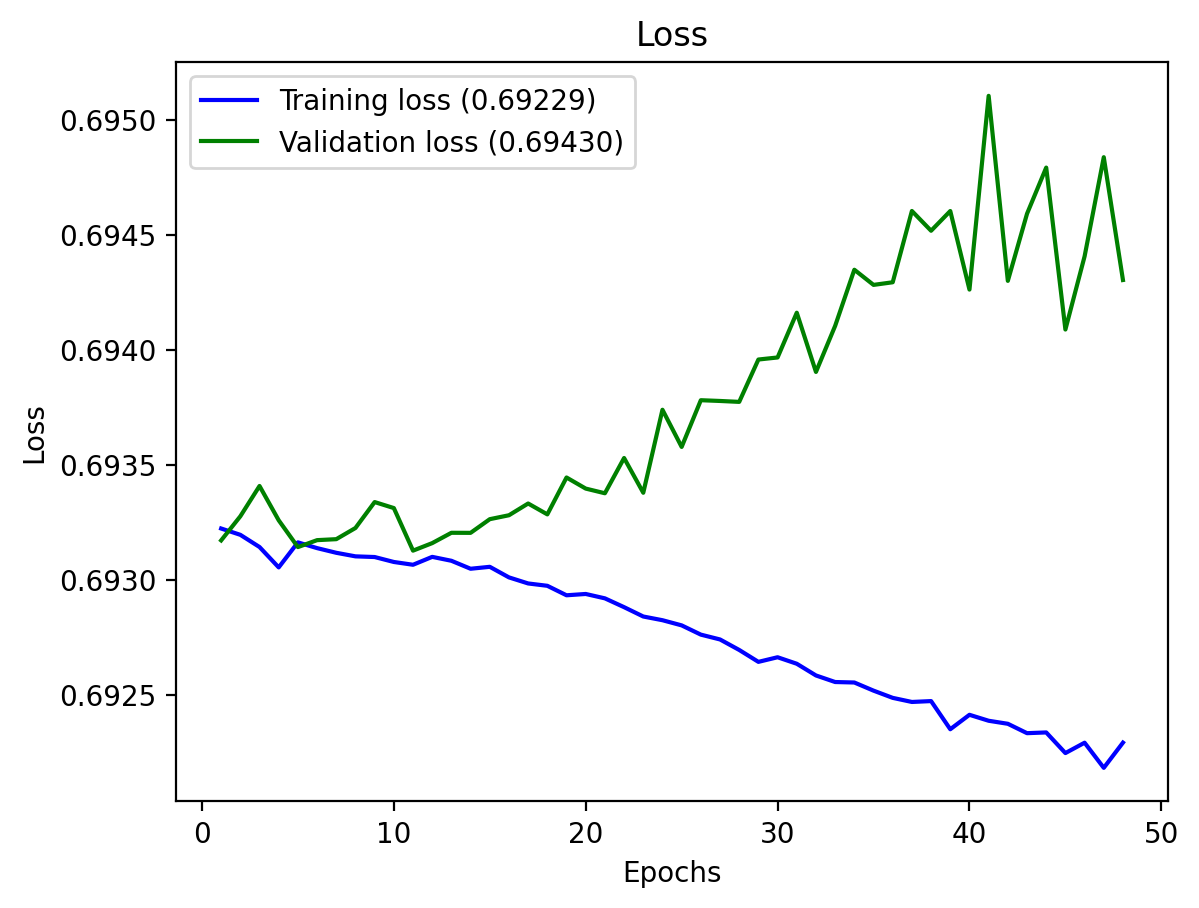

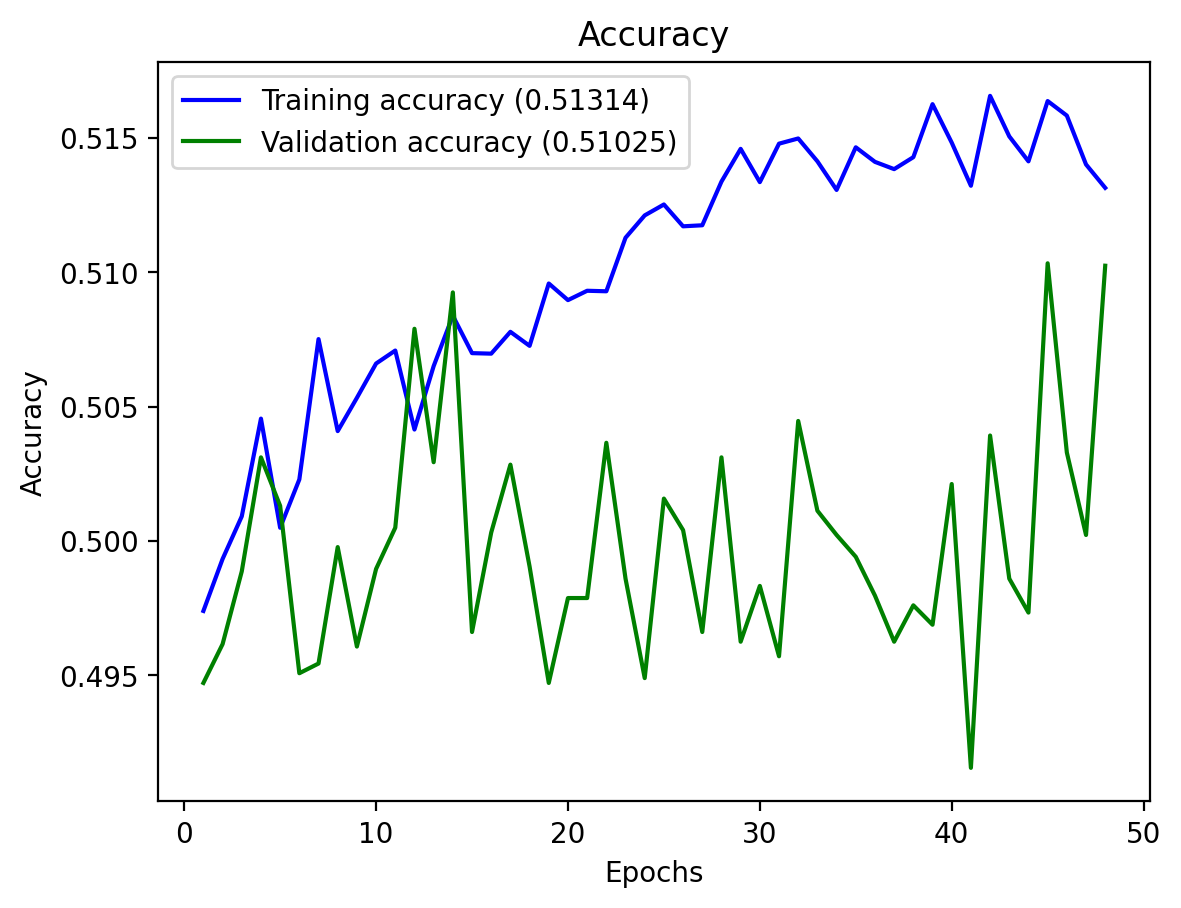

347/347 [==============================] - 3s 6ms/step
Accuracy : 0.51034
   precision    recall  f1-score  support
0   0.509476  0.615024  0.557297     5551
1   0.511654  0.405176  0.452232     5526


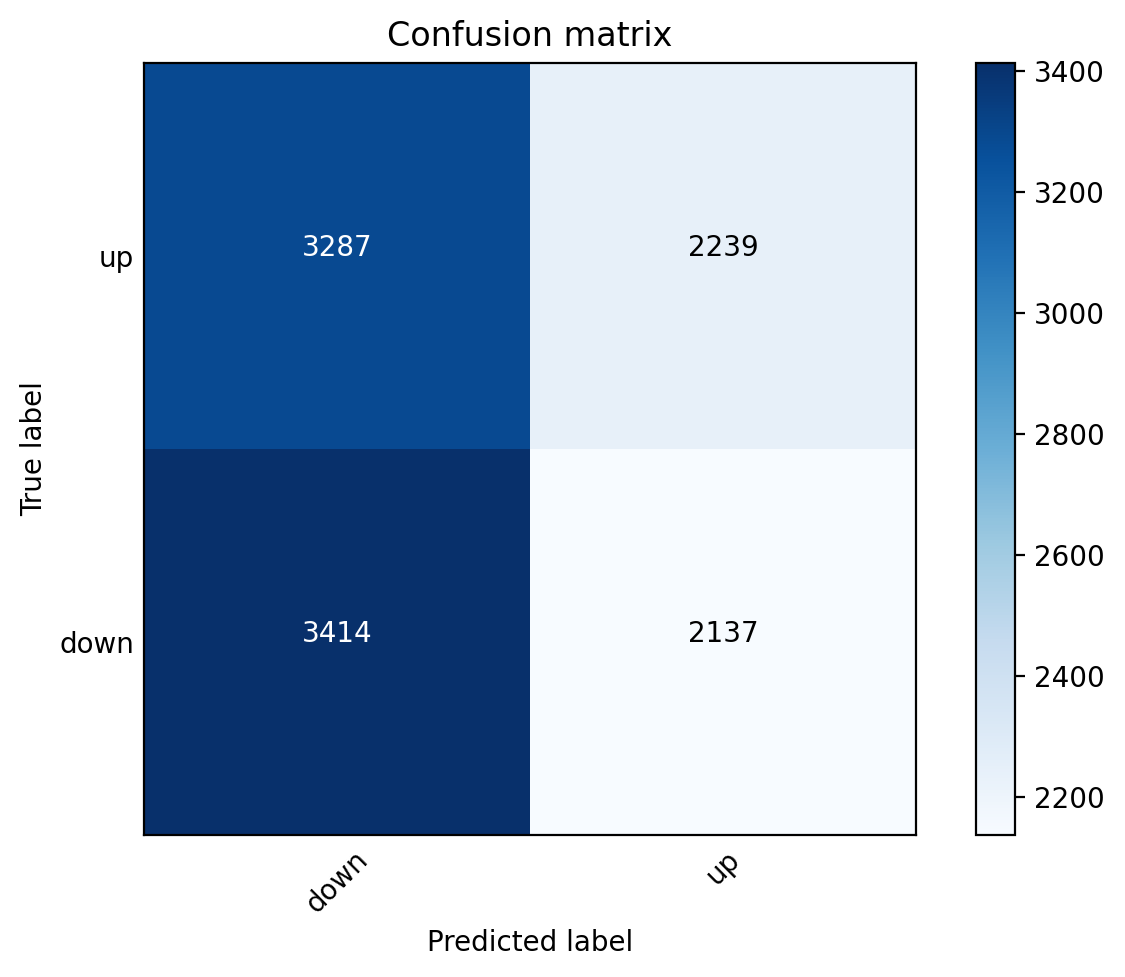

347/347 [==============================] - 2s 6ms/step


### EURUSD Model V1 Strategy

CY

_2024-04-24 17:31:31_

#### Setup

,
symbol,EURUSD
timescale,Hourly
spread,0.00000
starting equity,"10,000"
from,2018-03-27 01:00:00
to,2021-09-27 08:00:00


---

#### Performance Report

,All,Long,Short
Net P&L,"-7,198.30","-6,610.20",-588.10
Gross Profit,"203,182.00","75,704.00","127,478.00"
Gross Loss,"-210,380.30","-82,314.20","-128,066.10"
Profit Factor,0.97,0.92,1.00
Total # of Trades,"22,155.00","8,661.00","13,494.00"
Number Winning Trades,"11,106.00","4,405.00","6,701.00"
Number Losing Trades,"11,049.00","4,256.00","6,793.00"
Percent Profitable,0.50,0.51,0.50
Avg Trade Win Loss,-0.32,-0.76,-0.04
Avg Winning Trade,18.29,17.19,19.02


#### Performance/Risk Metrics

,,
slope,-0.5168,
r2,0.4649,
stderr,0.0037,
quality ratio,-64.4959,
Max Drawdown,17034.4,2021-09-07 20:00:00
Max Drawdown %,90.0 %,2021-09-07 20:00:00


#### Returns Metrics

,
Cumulative returns,-0.7198
Annual return,-0.2956
Average monthly return,-0.0199
Return Max Drawdown,-0.8989
MDD Recovery Period,11.0000
Longest Drawdown Period,665.0000
Mean daily loss,-0.0284
Worst daily loss,-0.2200
99% quantile daily loss,-0.1418
Worst monthly loss,-0.3355


#### Risk Adjusted Metrics

,
Sharpe,-0.4460
Sortino,-0.6217
Omega,0.9641
Calmar,-0.3288


#### Equity Curve

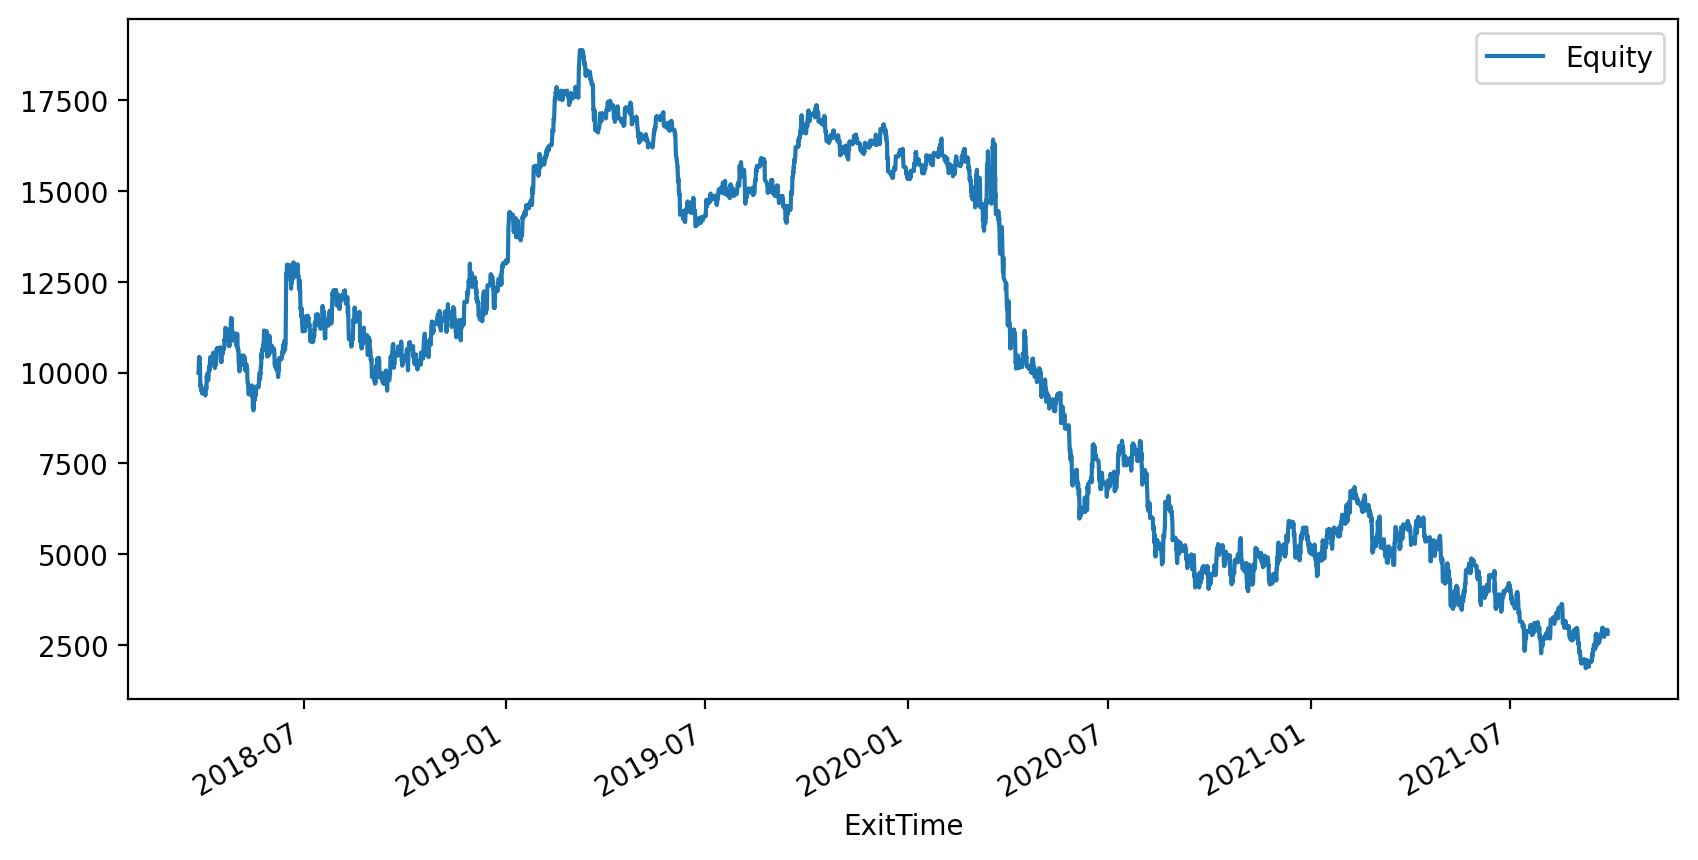

#### P&L Statistics

,Daily PL,Weekly PL,Monthly PL
count,911.00,184.00,43.00
mean,-7.90,-39.12,-167.40
std,285.15,684.17,"1,263.75"
min,-909.10,"-2,276.60","-2,976.60"
25%,-166.20,-381.90,-854.20
50%,-3.00,-56.65,66.00
75%,152.65,340.50,554.15
max,"1,856.50","2,565.70","2,632.60"


#### Monthly Returns

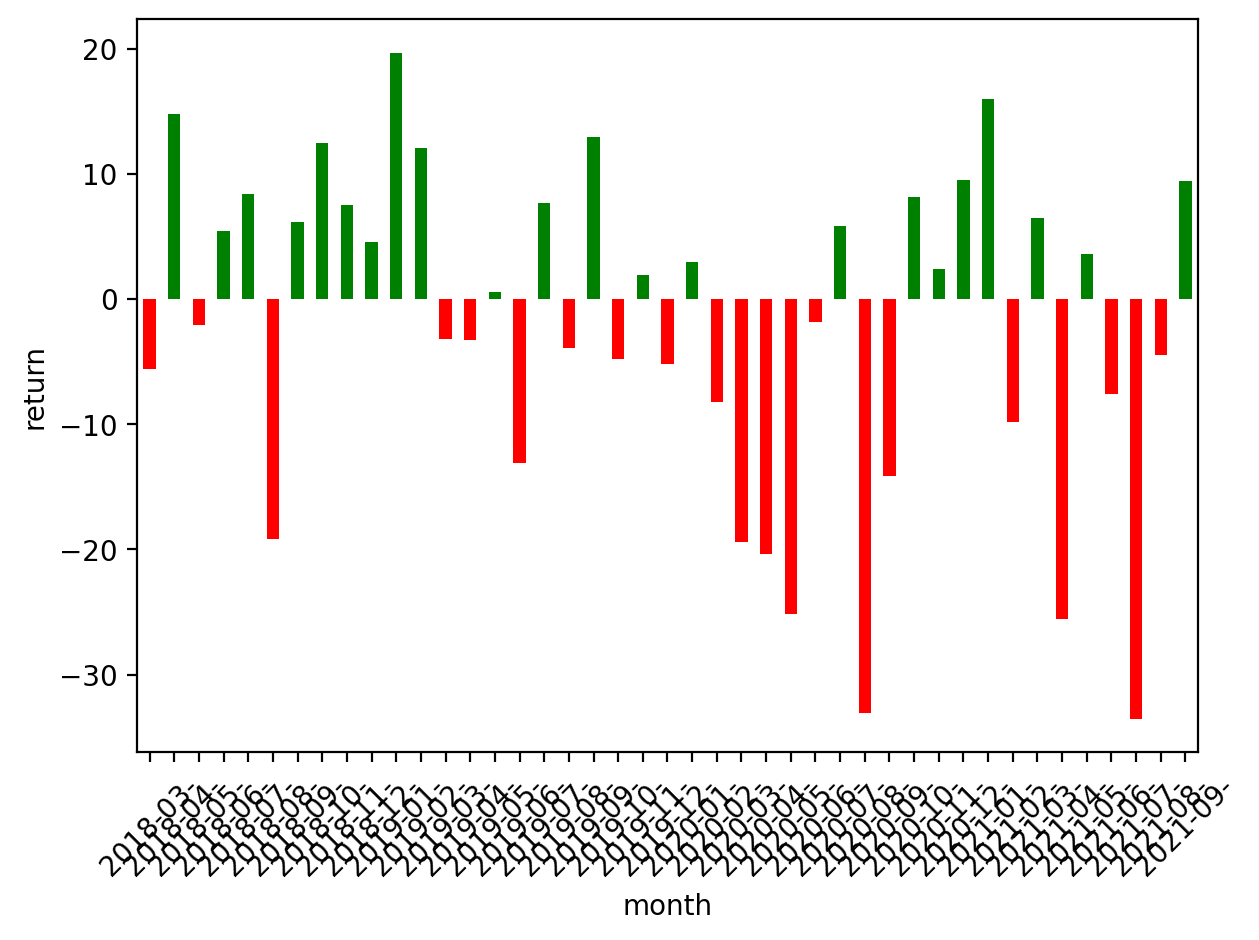

#### MAE/MFE

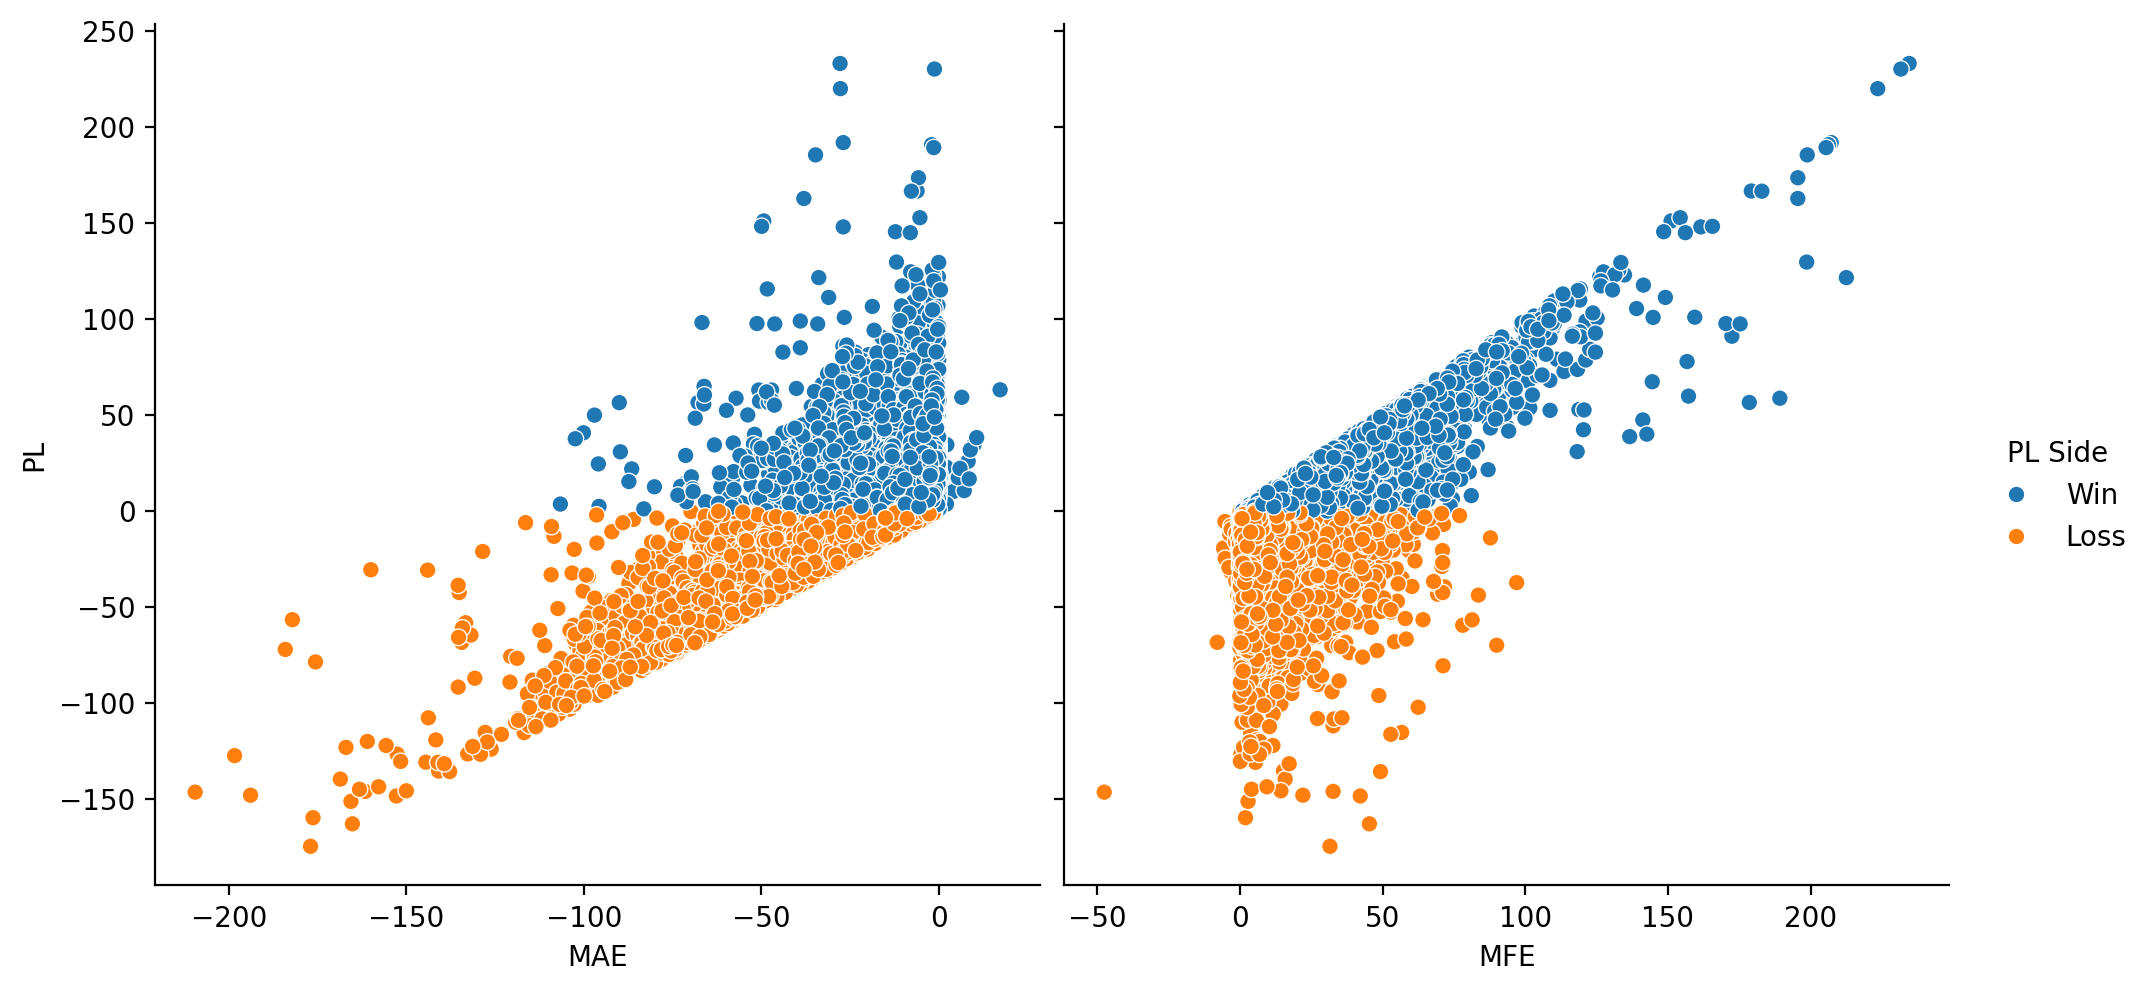

#### Trades

,Side,EntryPrice,EntryTime,ExitPrice,ExitTime,PointPL,TradeSize,PL,CumPL,Equity,Return,CumReturn,PLSign,MAE,MFE
date,,,,,,,,,,,,,,,
2018-03-27 01:00:00,SELL,1.24565,2018-03-27 01:00:00,1.24646,2018-03-27 09:00:00,-0.00081,"10,000",-8.1,-8.1,9991.9,-0.000810,-0.00081,-1,-19.2,14.9
2018-03-27 02:00:00,SELL,1.24489,2018-03-27 02:00:00,1.24294,2018-03-27 10:00:00,0.00195,"10,000",19.5,11.4,10011.4,0.001952,0.00114,1,-26.8,23.3
2018-03-27 03:00:00,SELL,1.24425,2018-03-27 03:00:00,1.24133,2018-03-27 11:00:00,0.00292,"10,000",29.2,40.6,10040.6,0.002917,0.00406,1,-33.2,33.1
2018-03-27 04:00:00,SELL,1.24460,2018-03-27 04:00:00,1.24064,2018-03-27 12:00:00,0.00396,"10,000",39.6,80.2,10080.2,0.003944,0.00802,1,-29.7,41.5
2018-03-27 05:00:00,SELL,1.24510,2018-03-27 05:00:00,1.23906,2018-03-27 13:00:00,0.00604,"10,000",60.4,140.6,10140.6,0.005992,0.01406,1,-24.7,62.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27 04:00:00,BUY,1.17182,2021-09-27 04:00:00,1.17070,2021-09-27 12:00:00,-0.00112,"10,000",-11.2,-7123.7,2876.3,-0.003879,-0.71237,-1,-34.4,6.1
2021-09-27 05:00:00,BUY,1.17218,2021-09-27 05:00:00,1.16914,2021-09-27 13:00:00,-0.00304,"10,000",-30.4,-7154.1,2845.9,-0.010569,-0.71541,-1,-38.0,2.5
2021-09-27 06:00:00,BUY,1.17217,2021-09-27 06:00:00,1.17068,2021-09-27 14:00:00,-0.00149,"10,000",-14.9,-7169.0,2831.0,-0.005236,-0.71690,-1,-37.9,2.0


256/256 [==============================] - 1s 6ms/step


### EURUSD Model V1 Strategy

CY

_2024-04-24 17:32:03_

#### Setup

,
symbol,EURUSD
timescale,Hourly
spread,0.00000
starting equity,"10,000"
from,2021-09-28 16:00:00
to,2023-01-10 23:00:00


---

#### Performance Report

,All,Long,Short
Net P&L,-1.80,"-3,768.10","3,766.30"
Gross Profit,"104,401.80","38,454.80","65,947.00"
Gross Loss,"-104,403.60","-42,222.90","-62,180.70"
Profit Factor,1.00,0.91,1.06
Total # of Trades,"8,178.00","3,225.00","4,953.00"
Number Winning Trades,"4,011.00","1,523.00","2,488.00"
Number Losing Trades,"4,167.00","1,702.00","2,465.00"
Percent Profitable,0.49,0.47,0.50
Avg Trade Win Loss,-0.00,-1.17,0.76
Avg Winning Trade,26.03,25.25,26.51


#### Performance/Risk Metrics

,,
slope,-0.0721,
r2,0.0124,
stderr,0.0071,
quality ratio,-0.1256,
Max Drawdown,7303.3,2023-01-03 05:00:00
Max Drawdown %,48.0 %,2023-01-03 05:00:00


#### Returns Metrics

,
Cumulative returns,-0.0002
Annual return,-0.0001
Average monthly return,0.0122
Return Max Drawdown,-0.4698
MDD Recovery Period,4.0000
Longest Drawdown Period,132.0000
Mean daily loss,-0.0258
Worst daily loss,-0.1038
99% quantile daily loss,-0.0915
Worst monthly loss,-0.3444


#### Risk Adjusted Metrics

,
Sharpe,-0.0002
Sortino,-0.0004
Omega,1.0472
Calmar,-0.0003


#### Equity Curve

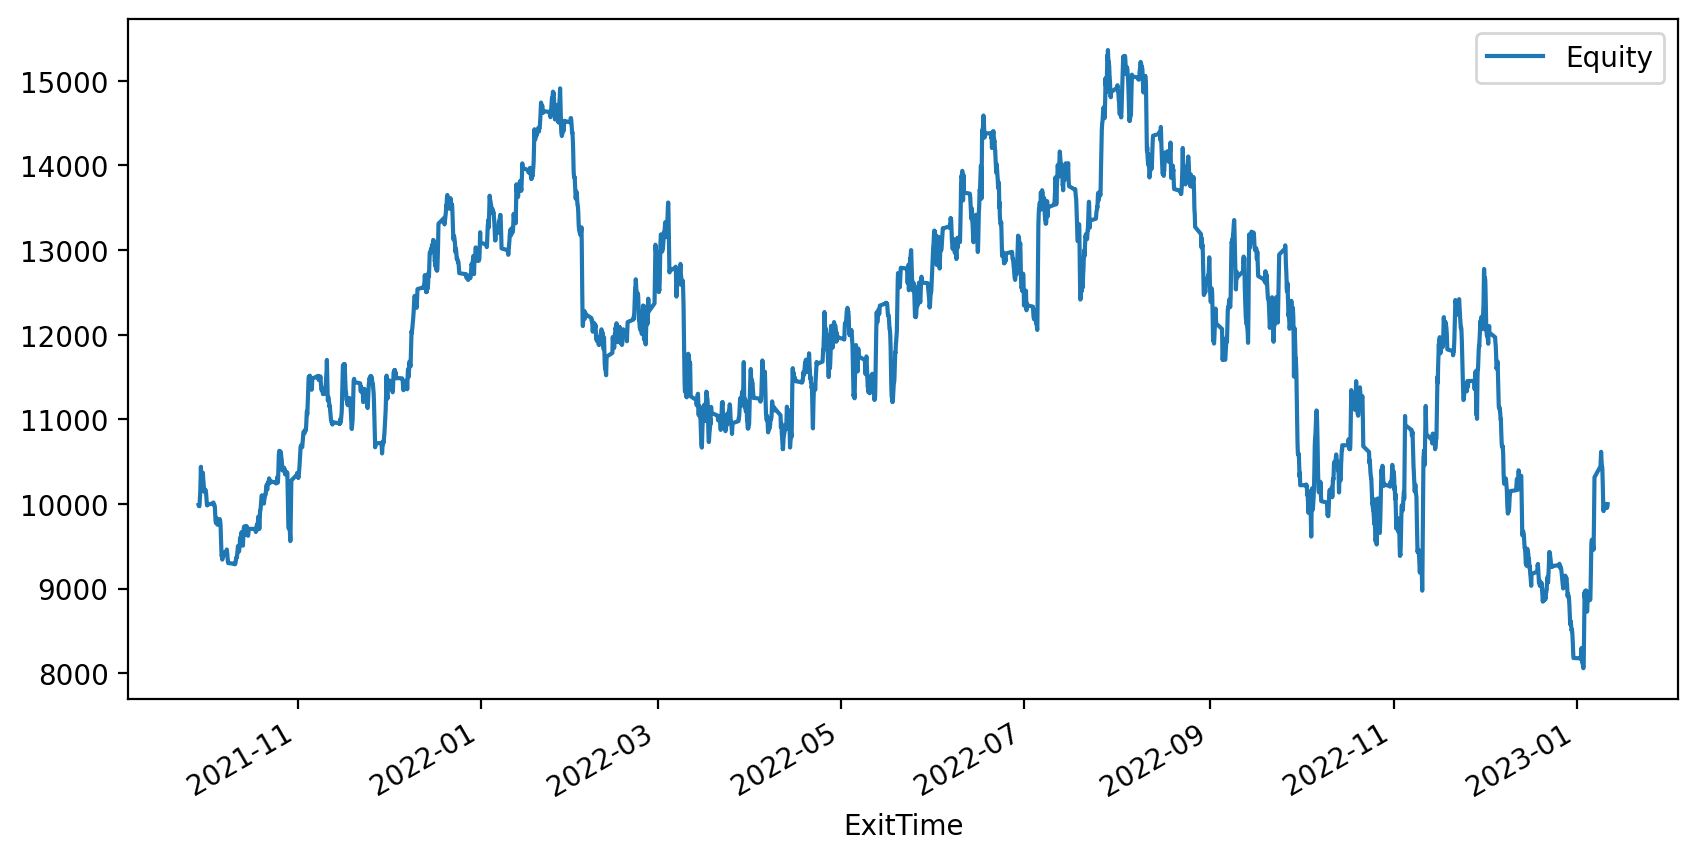

#### P&L Statistics

,Daily PL,Weekly PL,Monthly PL
count,336.00,68.00,17.00
mean,-0.01,-0.03,-0.11
std,392.42,864.06,"1,802.34"
min,"-1,274.50","-2,794.90","-4,171.50"
25%,-222.38,-427.62,-992.90
50%,-33.05,46.70,172.00
75%,216.47,534.12,"1,251.90"
max,"1,358.00","2,303.80","2,514.40"


#### Monthly Returns

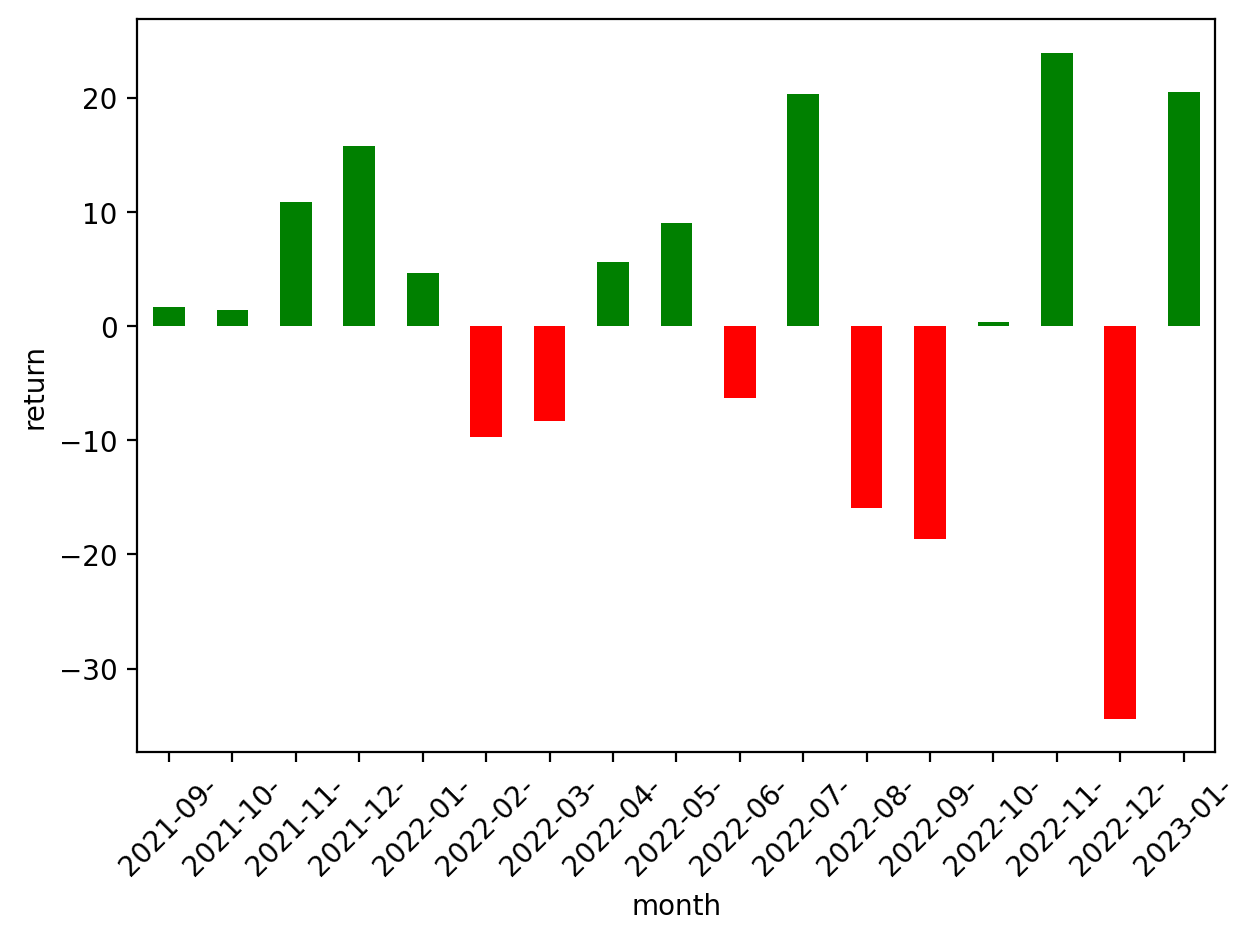

#### MAE/MFE

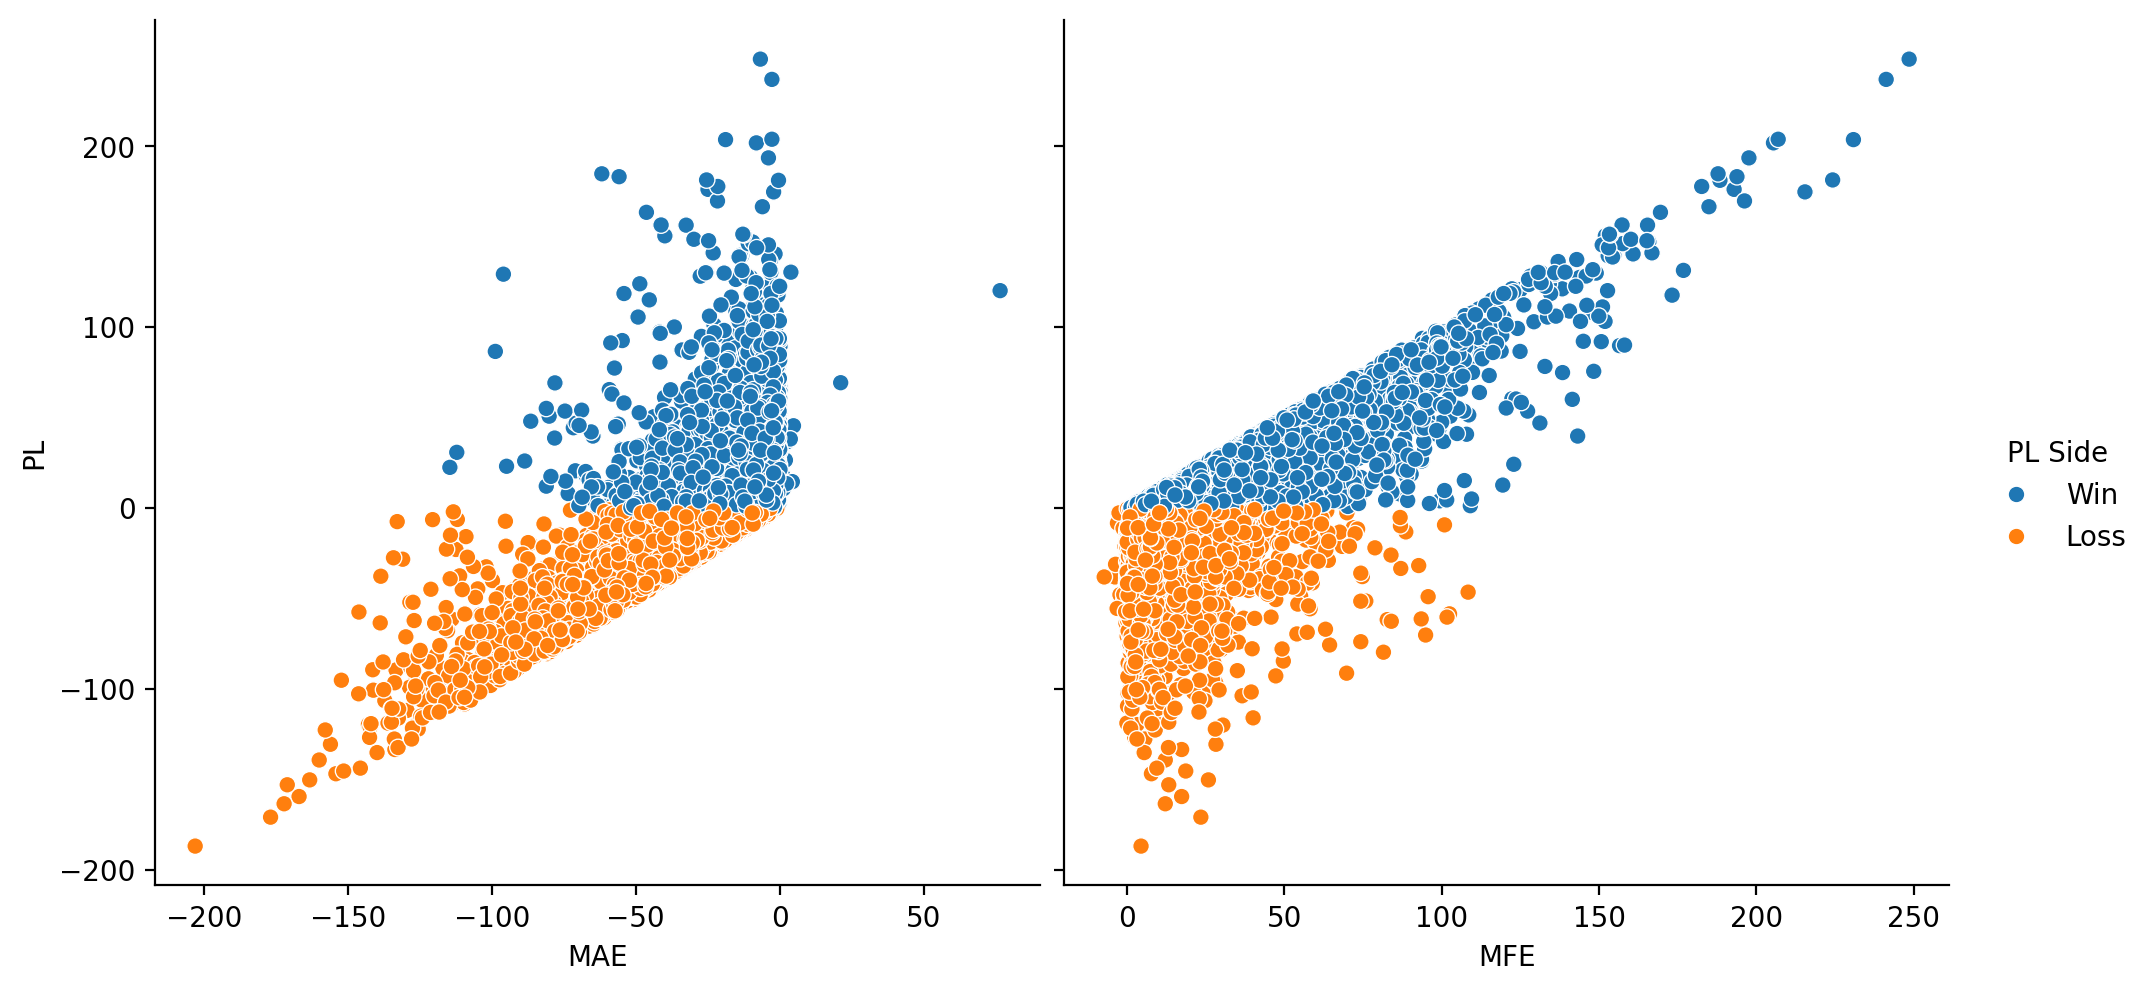

#### Trades

,Side,EntryPrice,EntryTime,ExitPrice,ExitTime,PointPL,TradeSize,PL,CumPL,Equity,Return,CumReturn,PLSign,MAE,MFE
date,,,,,,,,,,,,,,,
2021-09-28 16:00:00,SELL,1.16732,2021-09-28 16:00:00,1.16845,2021-09-29 00:00:00,-0.00113,"10,000",-11.3,-11.3,9988.7,-0.001130,-0.00113,-1,-16.4,5.7
2021-09-28 17:00:00,SELL,1.16802,2021-09-28 17:00:00,1.16854,2021-09-29 01:00:00,-0.00052,"10,000",-5.2,-16.5,9983.5,-0.000521,-0.00165,-1,-9.4,5.5
2021-09-28 18:00:00,SELL,1.16816,2021-09-28 18:00:00,1.16806,2021-09-29 02:00:00,0.00010,"10,000",1.0,-15.5,9984.5,0.000100,-0.00155,1,-7.0,6.9
2021-09-28 19:00:00,SELL,1.16787,2021-09-28 19:00:00,1.16809,2021-09-29 03:00:00,-0.00022,"10,000",-2.2,-17.7,9982.3,-0.000220,-0.00177,-1,-9.9,4.0
2021-09-28 20:00:00,SELL,1.16765,2021-09-28 20:00:00,1.16850,2021-09-29 04:00:00,-0.00085,"10,000",-8.5,-26.2,9973.8,-0.000852,-0.00262,-1,-13.1,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10 19:00:00,SELL,1.07381,2023-01-10 19:00:00,1.07267,2023-01-11 03:00:00,0.00114,"10,000",11.4,-32.8,9967.2,0.001145,-0.00328,1,-7.3,12.6
2023-01-10 20:00:00,SELL,1.07408,2023-01-10 20:00:00,1.07336,2023-01-11 04:00:00,0.00072,"10,000",7.2,-25.6,9974.4,0.000722,-0.00256,1,-4.6,15.3
2023-01-10 21:00:00,SELL,1.07359,2023-01-10 21:00:00,1.07386,2023-01-11 05:00:00,-0.00027,"10,000",-2.7,-28.3,9971.7,-0.000271,-0.00283,-1,-9.5,10.4


In [17]:
ClassifierReport(X_val,y_val,model,history,save_best_model, batch_size=batch_size)
## Backtest on val + test set
val_test_report = bt.classifier_backtest(df,                               
                        np.concatenate([model.predict(X_val),model.predict(X_test)]),
                        y_datetime[X_train.shape[0]:],
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)


## Backtest on backtest set
BT_report = bt.classifier_backtest(df,                               
                        model.predict(X_bck),
                        y_bck_datetime,
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)


##############################################################################################################

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
training_time = datetime.timedelta(seconds = callbacks[1].train_stop - callbacks[1].train_start)
best_acc_epoch = callbacks[0].best_epoch

val_test_PL = val_test_report['performance_report'].loc['Net P&L']['All']
val_test_nb_long_trades = val_test_report['performance_report'].loc['Total # of Trades']['Long']
val_test_nb_short_trade = val_test_report['performance_report'].loc['Total # of Trades']['Short']
val_test_sharpe = val_test_report['risk_adjusted_metrics']['Sharpe'][0]
val_test_sortino = val_test_report['risk_adjusted_metrics']['Sortino'][0]
val_test_max_drawdown = val_test_report['performance_risk_metrics']['Max Drawdown %'][0]

BT_PL =  BT_report['performance_report'].loc['Net P&L']['All']
BT_nb_long_trades = BT_report['performance_report'].loc['Total # of Trades']['Long']
BT_nb_short_trade= BT_report['performance_report'].loc['Total # of Trades']['Short']
BT_sharpe= BT_report['risk_adjusted_metrics']['Sharpe'][0]
BT_sortino = BT_report['risk_adjusted_metrics']['Sortino'][0]
BT_max_drawdown = BT_report['performance_risk_metrics']['Max Drawdown %'][0]

# df_results.loc[len(df_results)] = model_params.values()